In [4]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

In [3]:
import torch
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)
print(torch.rand(1, device="cuda"))




ModuleNotFoundError: No module named 'torch'

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from desc import set_device

# need to do this before importing other DESC stuff so JAX initializes properly
set_device("gpu")

In [7]:
"""Example script for recreating the precise QA configuration of Landreman and Paul."""


import numpy as np

from desc.continuation import solve_continuation_automatic
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.geometry import FourierRZToroidalSurface
from desc.grid import LinearGrid
from desc.objectives import (
    AspectRatio,
    FixBoundaryR,
    FixBoundaryZ,
    FixCurrent,
    FixPressure,
    FixPsi,
    ForceBalance,
    ObjectiveFunction,
    QuasisymmetryTwoTerm,
    RotationalTransform,
)
from desc.optimize import Optimizer

# create initial surface. Aspect ratio ~ 6, circular cross section with slight
# axis torsion to make it nonplanar
surf = FourierRZToroidalSurface(
    R_lmn=[1, 0.166, 0.1],
    Z_lmn=[-0.166, -0.1],
    modes_R=[[0, 0], [1, 0], [0, 1]],
    modes_Z=[[-1, 0], [0, -1]],
    NFP=2,
)
# create initial equilibrium. Psi chosen to give B ~ 1 T. Could also give profiles here,
# default is zero pressure and zero current
eq = Equilibrium(M=8, N=8, Psi=0.087, surface=surf)
# this is usually all you need to solve a fixed boundary equilibrium
eq = solve_continuation_automatic(eq, objective="force", bdry_step=0.5, verbose=3)[-1]
# it will be helpful to store intermediate results
eqfam = EquilibriaFamily(eq)

# create grid where we want to minimize QS error. Here we do it on 3 surfaces
grid = LinearGrid(M=eq.M, N=eq.N, NFP=eq.NFP, rho=np.array([0.6, 0.8, 1.0]), sym=True)

# optimize in steps
for k in range(1, eq.M + 1):
    print("\n==================================")
    print("Optimizing boundary modes M,N <= {}".format(k))
    print("====================================")
    objective = ObjectiveFunction(
        (
            # pass in the grid we defined, and don't forget the target helicity!
            QuasisymmetryTwoTerm(
                eq=eqfam[-1], helicity=(1, 0), grid=grid, normalize=False
            ),
            AspectRatio(eq=eqfam[-1], target=6, weight=1e1, normalize=False),
            # this targets a profile pointwise, which is ok because we expect it to be
            # fairly flat
            RotationalTransform(eq=eqfam[-1], target=0.42, weight=10, normalize=False),
            # we could optionally set normalize=True which would compute things in
            # normalized/dimensionless units, effectively changing the weights
        ),
        verbose=0,
    )
    print(objective)
    break
    """
    # as opposed to SIMSOPT and STELLOPT where variables are assumed fixed, in DESC
    # we assume variables are free. Here we decide which ones to fix, starting with
    # the major radius (R mode = [0,0,0]) and all modes with m,n > k
    R_modes = np.vstack(
        (
            [0, 0, 0],
            eq.surface.R_basis.modes[
                np.max(np.abs(eq.surface.R_basis.modes), 1) > k, :
            ],
        )
    )
    Z_modes = eq.surface.Z_basis.modes[
        np.max(np.abs(eq.surface.Z_basis.modes), 1) > k, :
    ]
    # next we create the constraints, using the mode number arrays just created
    # if we didn't pass those in, it would fix all the modes (like for the profiles)
    constraints = (
        ForceBalance(eq=eqfam[-1]),  # J x B - grad(p) = 0
        FixBoundaryR(eq=eqfam[-1], modes=R_modes),
        FixBoundaryZ(eq=eqfam[-1], modes=Z_modes),
        FixPressure(eq=eqfam[-1]),
        FixCurrent(eq=eqfam[-1]),
        FixPsi(eq=eqfam[-1]),
    )
    # this is the default optimizer, which re-solves the equilibrium at each step
    optimizer = Optimizer("proximal-lsq-exact")
    # we get a new equilibrium by optimizing the old one and passing copy=True.
    # otherwise, we could modify the original equilibrium in place
    eq_new, out = eqfam[-1].optimize(
        objective=objective,
        constraints=constraints,
        optimizer=optimizer,
        maxiter=50,
        verbose=3,
        copy=True,
        options={
            # sometimes the default initial trust radius is too big, allowing the
            # optimizer to take too large a step in a bad direction. If this happens,
            # we can manually specify a smaller starting radius.
            "initial_trust_radius": 0.5,
        },
    )
    # add our new equilibrium to the family
    eqfam.append(eq_new)
    """
# save all the steps of the optimization for later analysis
#eqfam.save("precise_QA_output.h5")

Step 1
Spectral indexing: ansi
Spectral resolution (L,M,N)=(4,4,0)
Node pattern: jacobi
Node resolution (L,M,N)=(8,8,0)
Boundary ratio = 0
Pressure ratio = 0
Current ratio = 1
Perturbation Order = 2
Objective: force
Optimizer: lsq-exact
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 177 ms
Timer: Objective build = 405 ms
Timer: Linear constraint projection build = 1.62 sec
Compiling objective function and derivatives: ['force']
Timer: Objective compilation time = 1.18 sec
Timer: Jacobian compilation time = 3.07 sec
Timer: Total compilation time = 4.26 sec
Number of parameters: 12
Number of objectives: 50
Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          3.046e-02                                    1.558e+01   
       1              2          3.288e-04      3.013e-02      1.627e-01      1.985e+00   
       2              3          

In [4]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


/home/dw1978/.conda/envs/descv2-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


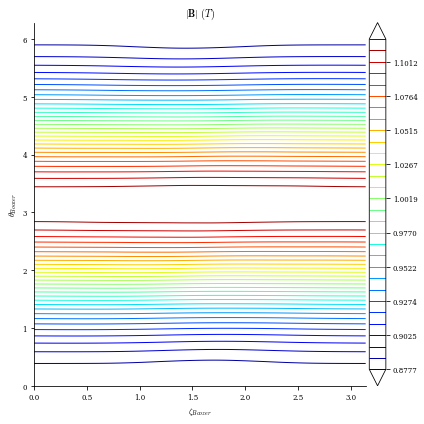

In [6]:
from desc.plotting import (
    plot_grid,
    plot_boozer_modes,
    plot_boozer_surface,
    plot_qs_error,
)

plot_boozer_surface(eqfam[-1]);

/home/dw1978/.conda/envs/descv2-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


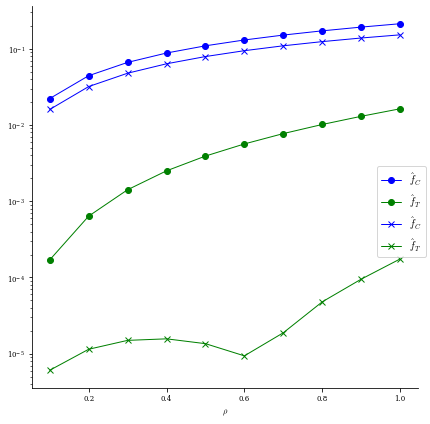

In [8]:
# compare f_T & f_C before (o) vs after (x) optimization
fig, ax = plot_qs_error(
    eqfam[0], helicity=(1, eqfam[0].NFP), fB=False, legend=False, rho=10
)
plot_qs_error(
    eqfam[-1], helicity=(1, eqfam[-1].NFP), fB=False, ax=ax, markers=["x", "x"], rho=10
);